# Pytorchによる Encoder-Decoderの学習

In [1]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from sklearn.cluster import KMeans
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import  datasets, transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [5]:
out_dir = 'autoencoder'
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(
                              [0.5,0.5,0.5],
                              [0.5,0.5,0.5])
                            ])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [54]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [35]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),          
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),          
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    

# autoencoder = Autoencoder().cuda()

In [65]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder.parameters())

In [67]:
for epoch in range(50):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(trainloader, 0):
        inputs = inputs.cuda()
        
        #Forward
        encoded, outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log
        running_loss += loss.data
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 0.173
[1,  4000] loss: 0.155
[1,  6000] loss: 0.150
[1,  8000] loss: 0.148
[1, 10000] loss: 0.147
[1, 12000] loss: 0.148
[2,  2000] loss: 0.147
[2,  4000] loss: 0.147
[2,  6000] loss: 0.145
[2,  8000] loss: 0.146
[2, 10000] loss: 0.146
[2, 12000] loss: 0.144
[3,  2000] loss: 0.144
[3,  4000] loss: 0.146
[3,  6000] loss: 0.145
[3,  8000] loss: 0.145
[3, 10000] loss: 0.145
[3, 12000] loss: 0.144
[4,  2000] loss: 0.146
[4,  4000] loss: 0.145
[4,  6000] loss: 0.144
[4,  8000] loss: 0.145
[4, 10000] loss: 0.145
[4, 12000] loss: 0.143
[5,  2000] loss: 0.144
[5,  4000] loss: 0.143
[5,  6000] loss: 0.145
[5,  8000] loss: 0.144
[5, 10000] loss: 0.144
[5, 12000] loss: 0.144
[6,  2000] loss: 0.145
[6,  4000] loss: 0.144
[6,  6000] loss: 0.145
[6,  8000] loss: 0.142
[6, 10000] loss: 0.143
[6, 12000] loss: 0.144
[7,  2000] loss: 0.144
[7,  4000] loss: 0.142
[7,  6000] loss: 0.144
[7,  8000] loss: 0.144
[7, 10000] loss: 0.144
[7, 12000] loss: 0.144
[8,  2000] loss: 0.143
[8,  4000] 

In [68]:
#model save
torch.save(autoencoder.state_dict(), "weights/autoencoder.pkl")

## k-meansによるクラスタリング

In [112]:
# get some random test images
testloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
dataiter = iter(testloader)
images, labels = dataiter.next()

In [113]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# # show images
# imshow(torchvision.utils.make_grid(images[0:7]))

In [114]:
autoencoder = Autoencoder().cuda()
autoencoder.load_state_dict(torch.load('weights/autoencoder.pkl'))

<All keys matched successfully>

In [115]:
#tesor to numpy
images = images.cuda()
testencoded, testoutputs = autoencoder(images)
testencoded.cpu().detach().numpy().shape

(100, 48, 4, 4)

In [116]:
#flatten
test = testencoded.cpu().detach()
test= torch.flatten(test,start_dim=1).numpy()
test.shape

(100, 768)

## 5つのグループにクラスタリング

In [117]:
kmeans_model = KMeans(n_clusters=5, random_state=10).fit_predict(test)

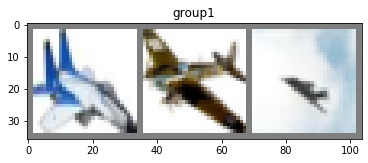

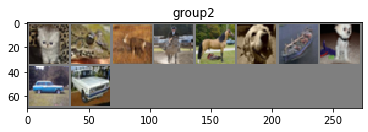

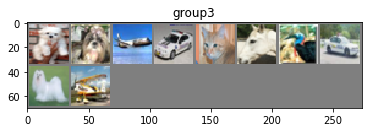

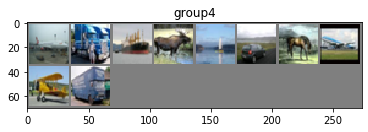

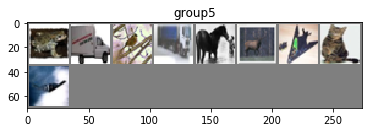

In [121]:
for i in range(5):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(images[kmeans_model == i][0:10].cpu()))


## 10グループでクラスタリング

In [119]:
kmeans_model2 = KMeans(n_clusters=10, random_state=10).fit_predict(test)

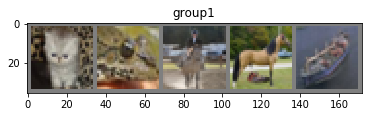

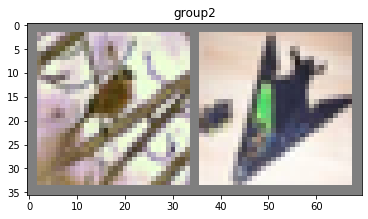

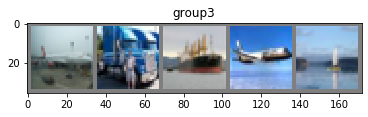

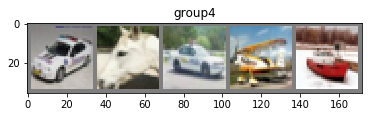

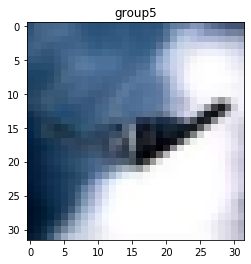

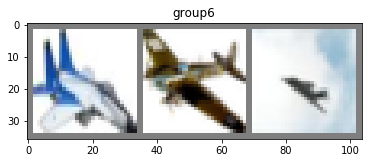

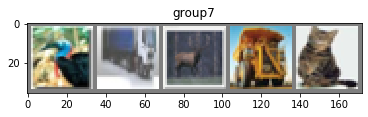

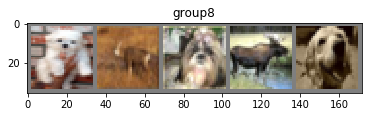

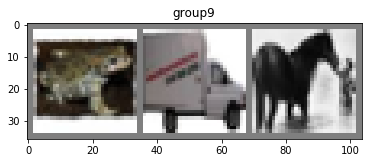

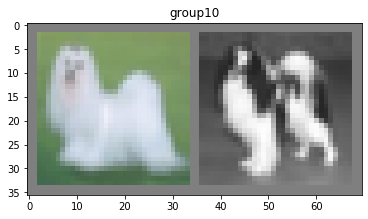

In [122]:
for i in range(10):
    plt.title('group'+ str(i+1))
    imshow(torchvision.utils.make_grid(images[kmeans_model2 == i][0:5].cpu()))

# 考察
AutoEncoderを学習しk-meansによるクラスタリングを行った。クラスタリングされたものを出力してみた結果、動物は動物のグループを作り機械は機械のグループを作っているように見えた。実際、精度が高いものとは言えなかった。原因として考えられるのは、Encoderの出力を単純にflattenしてしまったものをクラスタリングしたことによって画像の特徴情報が消失してしまったものであると考えられる。